# Introduction to py2cytoscape: Pythonista-friendly wrapper for cyREST

## Requirments 
* Java 8
* Cytoscape 3.2.1+
* py2cytoscape 0.4.2+

## Environment Setup

What is py2cytoscape?

* A python package to drive Cytoscape in a pythonic way 

### Initial setup : 

In [1]:
from py2cytoscape.data.cynetwork import CyNetwork
from py2cytoscape.data.cyrest_client import CyRestClient
from py2cytoscape.data.style import StyleUtil
import py2cytoscape.util.cytoscapejs as cyjs
import py2cytoscape.cytoscapejs as renderer
from IPython.display import Image

import networkx as nx
import pandas as pd
import json
import os
import sys

C:\Users\ajshe\Anaconda3\envs\py2cyto_sandbox\lib\site-packages\py2cytoscape\data\base_view.py:8: UserWarning: 


**** data.base_view will be deprecated in the next py2cytoscape release. ****



  warnings.warn('\n\n\n**** data.base_view will be deprecated in the next py2cytoscape release. ****\n\n\n')
C:\Users\ajshe\Anaconda3\envs\py2cyto_sandbox\lib\site-packages\py2cytoscape\data\edge_view.py:8: UserWarning: 


**** data.edge_view will be deprecated in the next py2cytoscape release. ****



  warnings.warn('\n\n\n**** data.edge_view will be deprecated in the next py2cytoscape release. ****\n\n\n')
C:\Users\ajshe\Anaconda3\envs\py2cyto_sandbox\lib\site-packages\py2cytoscape\data\node_view.py:10: UserWarning: 


**** data.node_view will be deprecated in the next py2cytoscape release. ****



  warnings.warn('\n\n\n**** data.node_view will be deprecated in the next py2cytoscape release. ****\n\n\n')
C:\Users\ajshe\Anaconda3\envs\py2cyto_sandbox\lib\site-packages\py2cytoscape\data\util_

<IPython.core.display.Javascript object>

# Six step (basic) Workflow

1. create the py2cytoscape client and reset Cytoscape session
2. load the network data from somewhere
3. load the table as a pandas DataFrame (optional - can load data directly depending on data file type)
4. Merge data into Cytoscape 
5. Apply layout 
6. Create visual style (optional)

In [18]:
# !!!!!!!!!!!!!!!!! Step 0: Start Cytoscape 3 with cyREST App !!!!!!!!!!!!!!!!!!!!!!!!!!

# Step 1: Create py2cytoscape client
cy = CyRestClient()


# Reset
cy.session.delete()

# Step 2: Load network from somewhere
yeast_net = cy.network.create_from('galFiltered.sif')

# Step 3: Load table as pandas' DataFrame
table_data = pd.read_csv('sample_data_table.csv', index_col=0)
table_data.head()

,alias,annotation.DB_Object_Name,annotation.GO BIOLOGICAL_PROCESS,annotation.GO CELLULAR_COMPONENT,annotation.GO MOLECULAR_FUNCTION,label,kegg,uniprot,sgd,entrez
YAL003W,"translation elongation factor EF-1beta, EF-1 b...","EF-1 beta, translation elongation factor EF-1beta",translational elongation,eukaryotic translation elongation factor 1 com...,translation elongation factor activity,EF1B,sce:YAL003W,EF1B_YEAST,S000000003,851260
YAL030W,"S000000028, SNC1",NaN,"Golgi to plasma membrane transport, endocytosi...","Golgi trans face, SNARE complex, endosome, tra...",v-SNARE activity,SNC1,sce:YAL030W,SNC1_YEAST,S000000028,851203
YAL038W,"CDC19, PYK1, S000000036, pyruvate kinase",pyruvate kinase,"glycolysis, pyruvate metabolic process",cytosol,pyruvate kinase activity,KPYK1,sce:YAL038W,KPYK1_YEAST,S000000036,851193
YAL040C,"CLN3, DAF1, FUN10, G1 cyclin, S000000038, WHI1",G1 cyclin,"G1/S transition of mitotic cell cycle, regulat...",nucleus,cyclin-dependent protein kinase regulator acti...,CG13,sce:YAL040C,CG13_YEAST,S000000038,851191
YAR007C,heterotrimeric RPA (RF-A) single-stranded DNA ...,"RF-A, heterotrimeric RPA (RF-A) single-strande...","DNA recombination, DNA replication, synthesis ...","DNA replication factor A complex, chromosome, ...","damaged DNA binding, single-stranded DNA binding",RFA1,sce:YAR007C,RFA1_YEAST,S000000065,851266


In [19]:
import pprint
all_suid = cy.network.get_all()
net1 = cy.network.create(all_suid[0])
pprint.pprint(net1.get_first_view())

{'data': {'SUID': 2880,
          '__Annotations': [],
          'name': 'galFiltered.sif',
          'selected': True,
          'shared_name': 'galFiltered.sif',
          'source_location': 'file:///C:\\Users\\ajshe\\OneDrive\\Documents\\Gitter_Lab_research\\CytoscapeAutomation\\py2cytoscape\\galFiltered.sif'},
 'elements': {'edges': [{'data': {'SUID': 3581,
                                  'id': '3581',
                                  'interaction': 'pp',
                                  'name': 'YDR277C (pp) YDL194W',
                                  'selected': False,
                                  'shared_interaction': 'pp',
                                  'shared_name': 'YDR277C (pp) YDL194W',
                                  'source': '3578',
                                  'target': '3580'},
                         'selected': False},
                        {'data': {'SUID': 3579,
                                  'id': '3579',
                                 

                                  'selected': False,
                                  'shared_interaction': 'pp',
                                  'shared_name': 'YDR395W (pp) YPR102C',
                                  'source': '3488',
                                  'target': '3407'},
                         'selected': False},
                        {'data': {'SUID': 3560,
                                  'id': '3560',
                                  'interaction': 'pp',
                                  'name': 'YDR395W (pp) YOL127W',
                                  'selected': False,
                                  'shared_interaction': 'pp',
                                  'shared_name': 'YDR395W (pp) YOL127W',
                                  'source': '3488',
                                  'target': '2982'},
                         'selected': False},
                        {'data': {'SUID': 3559,
                                  'id': '3559',
           

                                  'source': '3377',
                                  'target': '3355'},
                         'selected': False},
                        {'data': {'SUID': 3375,
                                  'id': '3375',
                                  'interaction': 'pp',
                                  'name': 'YDR167W (pp) YLR432W',
                                  'selected': False,
                                  'shared_interaction': 'pp',
                                  'shared_name': 'YDR167W (pp) YLR432W',
                                  'source': '3373',
                                  'target': '3374'},
                         'selected': False},
                        {'data': {'SUID': 3372,
                                  'id': '3372',
                                  'interaction': 'pp',
                                  'name': 'YLR175W (pp) YNL307C',
                                  'selected': False,
                         

                        {'data': {'SUID': 3273,
                                  'id': '3273',
                                  'interaction': 'pp',
                                  'name': 'YGR048W (pp) YPL222W',
                                  'selected': False,
                                  'shared_interaction': 'pp',
                                  'shared_name': 'YGR048W (pp) YPL222W',
                                  'source': '3271',
                                  'target': '3272'},
                         'selected': False},
                        {'data': {'SUID': 3270,
                                  'id': '3270',
                                  'interaction': 'pp',
                                  'name': 'YMR291W (pp) YGL115W',
                                  'selected': False,
                                  'shared_interaction': 'pp',
                                  'shared_name': 'YMR291W (pp) YGL115W',
                                  'sourc

                                  'name': '? (pd) YGL035C',
                                  'selected': False,
                                  'shared_interaction': 'pd',
                                  'shared_name': '? (pd) YGL035C',
                                  'source': '3203',
                                  'target': '3053'},
                         'selected': False},
                        {'data': {'SUID': 3204,
                                  'id': '3204',
                                  'interaction': 'pd',
                                  'name': '? (pd) YKR099W',
                                  'selected': False,
                                  'shared_interaction': 'pd',
                                  'shared_name': '? (pd) YKR099W',
                                  'source': '3203',
                                  'target': '3064'},
                         'selected': False},
                        {'data': {'SUID': 3202,
                 

                        {'data': {'SUID': 3516,
                                  'id': '3516',
                                  'interaction': 'pp',
                                  'name': 'YJL157C (pp) YOR212W',
                                  'selected': False,
                                  'shared_interaction': 'pp',
                                  'shared_name': 'YJL157C (pp) YOR212W',
                                  'source': '3127',
                                  'target': '3515'},
                         'selected': False},
                        {'data': {'SUID': 3514,
                                  'id': '3514',
                                  'interaction': 'pp',
                                  'name': 'YJL157C (pp) YAL040C',
                                  'selected': False,
                                  'shared_interaction': 'pp',
                                  'shared_name': 'YJL157C (pp) YAL040C',
                                  'sourc

                        {'data': {'SUID': 3086,
                                  'id': '3086',
                                  'interaction': 'pp',
                                  'name': 'YGR058W (pp) YOR264W',
                                  'selected': False,
                                  'shared_interaction': 'pp',
                                  'shared_name': 'YGR058W (pp) YOR264W',
                                  'source': '3085',
                                  'target': '3080'},
                         'selected': False},
                        {'data': {'SUID': 3409,
                                  'id': '3409',
                                  'interaction': 'pp',
                                  'name': 'YLR229C (pp) YJL157C',
                                  'selected': False,
                                  'shared_interaction': 'pp',
                                  'shared_name': 'YLR229C (pp) YJL157C',
                                  'sourc

                                  'shared_name': 'YOL051W (pd) YLR081W',
                                  'source': '3051',
                                  'target': '3057'},
                         'selected': False},
                        {'data': {'SUID': 3056,
                                  'id': '3056',
                                  'interaction': 'pd',
                                  'name': 'YOL051W (pd) YBR020W',
                                  'selected': False,
                                  'shared_interaction': 'pd',
                                  'shared_name': 'YOL051W (pd) YBR020W',
                                  'source': '3051',
                                  'target': '3055'},
                         'selected': False},
                        {'data': {'SUID': 3054,
                                  'id': '3054',
                                  'interaction': 'pd',
                                  'name': 'YBR019C (pd) YGL035C',
     

                                  'selected': False,
                                  'shared_interaction': 'pp',
                                  'shared_name': 'YLR117C (pp) YBR190W',
                                  'source': '3001',
                                  'target': '3341'},
                         'selected': False},
                        {'data': {'SUID': 3143,
                                  'id': '3143',
                                  'interaction': 'pd',
                                  'name': 'YGL013C (pd) YOL156W',
                                  'selected': False,
                                  'shared_interaction': 'pd',
                                  'shared_name': 'YGL013C (pd) YOL156W',
                                  'source': '2999',
                                  'target': '3142'},
                         'selected': False},
                        {'data': {'SUID': 3141,
                                  'id': '3141',
           

                        {'data': {'SUID': 2958,
                                  'id': '2958',
                                  'interaction': 'pd',
                                  'name': 'YNL216W (pd) YCR012W',
                                  'selected': False,
                                  'shared_interaction': 'pd',
                                  'shared_name': 'YNL216W (pd) YCR012W',
                                  'source': '2956',
                                  'target': '2957'},
                         'selected': False},
                        {'data': {'SUID': 3310,
                                  'id': '3310',
                                  'interaction': 'pd',
                                  'name': 'YAL038W (pd) YPL075W',
                                  'selected': False,
                                  'shared_interaction': 'pd',
                                  'shared_name': 'YAL038W (pd) YPL075W',
                                  'sourc

                        {'data': {'SUID': 2909,
                                  'id': '2909',
                                  'interaction': 'pp',
                                  'name': 'YDR429C (pp) YFL017C',
                                  'selected': False,
                                  'shared_interaction': 'pp',
                                  'shared_name': 'YDR429C (pp) YFL017C',
                                  'source': '2906',
                                  'target': '2908'},
                         'selected': False},
                        {'data': {'SUID': 2907,
                                  'id': '2907',
                                  'interaction': 'pp',
                                  'name': 'YMR146C (pp) YDR429C',
                                  'selected': False,
                                  'shared_interaction': 'pp',
                                  'shared_name': 'YMR146C (pp) YDR429C',
                                  'sourc

                                  'shared_name': 'YDL088C'},
                         'position': {'x': 632.1235310836862,
                                      'y': 1287.259207643411},
                         'selected': False},
                        {'data': {'SUID': 3525,
                                  'id': '3525',
                                  'name': 'YOR215C',
                                  'selected': False,
                                  'shared_name': 'YOR215C'},
                         'position': {'x': 500.3825633331369,
                                      'y': 1768.8214406146024},
                         'selected': False},
                        {'data': {'SUID': 3523,
                                  'id': '3523',
                                  'name': 'YPR010C',
                                  'selected': False,
                                  'shared_name': 'YPR010C'},
                         'position': {'x': -1010.3949177459647,
        

                                  'selected': False,
                                  'shared_name': 'YPL240C'},
                         'position': {'x': -842.1255696014334,
                                      'y': -508.26268871889374},
                         'selected': False},
                        {'data': {'SUID': 3407,
                                  'id': '3407',
                                  'name': 'YPR102C',
                                  'selected': False,
                                  'shared_name': 'YPR102C'},
                         'position': {'x': -572.5620930389334,
                                      'y': -1224.373646818259},
                         'selected': False},
                        {'data': {'SUID': 3406,
                                  'id': '3406',
                                  'name': 'YLR075W',
                                  'selected': False,
                                  'shared_name': 'YLR075W'},
               

                                      'y': -323.0914812909152},
                         'selected': False},
                        {'data': {'SUID': 3303,
                                  'id': '3303',
                                  'name': 'YER145C',
                                  'selected': False,
                                  'shared_name': 'YER145C'},
                         'position': {'x': -548.5164559081961,
                                      'y': 1903.4806126727078},
                         'selected': False},
                        {'data': {'SUID': 3302,
                                  'id': '3302',
                                  'name': 'YMR058W',
                                  'selected': False,
                                  'shared_name': 'YMR058W'},
                         'position': {'x': -551.5339081481864,
                                      'y': 2011.2027806414578},
                         'selected': False},
                     

                         'position': {'x': -665.5136921600272,
                                      'y': -711.2455950604465},
                         'selected': False},
                        {'data': {'SUID': 3241,
                                  'id': '3241',
                                  'name': 'YPR062W',
                                  'selected': False,
                                  'shared_name': 'YPR062W'},
                         'position': {'x': -58.89672591246858,
                                      'y': -1087.1658221112277},
                         'selected': False},
                        {'data': {'SUID': 3238,
                                  'id': '3238',
                                  'name': 'YPL111W',
                                  'selected': False,
                                  'shared_name': 'YPL111W'},
                         'position': {'x': -62.523572225945145,
                                      'y': -1373.8042498456027},


                                  'id': '3170',
                                  'name': 'YHR030C',
                                  'selected': False,
                                  'shared_name': 'YHR030C'},
                         'position': {'x': -176.67329909362093,
                                      'y': -661.5229998456027},
                         'selected': False},
                        {'data': {'SUID': 3169,
                                  'id': '3169',
                                  'name': 'YPL089C',
                                  'selected': False,
                                  'shared_name': 'YPL089C'},
                         'position': {'x': -232.96431471862093,
                                      'y': -499.1949969159152},
                         'selected': False},
                        {'data': {'SUID': 3167,
                                  'id': '3167',
                                  'name': 'YGL208W',
                           

                                  'shared_name': 'YJR109C'},
                         'position': {'x': -504.14525343932405,
                                      'y': 1608.3730458392117},
                         'selected': False},
                        {'data': {'SUID': 3085,
                                  'id': '3085',
                                  'name': 'YGR058W',
                                  'selected': False,
                                  'shared_name': 'YGR058W'},
                         'position': {'x': 1275.7945353790353,
                                      'y': -1211.3329974041965},
                         'selected': False},
                        {'data': {'SUID': 3083,
                                  'id': '3083',
                                  'name': 'YLR229C',
                                  'selected': False,
                                  'shared_name': 'YLR229C'},
                         'position': {'x': 157.55539963684782,
    

                                      'y': -1302.663930021384},
                         'selected': False},
                        {'data': {'SUID': 3032,
                                  'id': '3032',
                                  'name': 'YOL058W',
                                  'selected': False,
                                  'shared_name': 'YOL058W'},
                         'position': {'x': -133.19051100768343,
                                      'y': -1183.9635516034152},
                         'selected': False},
                        {'data': {'SUID': 3030,
                                  'id': '3030',
                                  'name': 'YBR248C',
                                  'selected': False,
                                  'shared_name': 'YBR248C'},
                         'position': {'x': -377.2652790740897,
                                      'y': -1166.6080828534152},
                         'selected': False},
                  

                         'selected': False},
                        {'data': {'SUID': 2953,
                                  'id': '2953',
                                  'name': 'YNL307C',
                                  'selected': False,
                                  'shared_name': 'YNL307C'},
                         'position': {'x': -335.9034626678397,
                                      'y': -416.7762652264621},
                         'selected': False},
                        {'data': {'SUID': 2951,
                                  'id': '2951',
                                  'name': 'YDL013W',
                                  'selected': False,
                                  'shared_name': 'YDL013W'},
                         'position': {'x': 150.76607010803923,
                                      'y': 109.24659243955352},
                         'selected': False},
                        {'data': {'SUID': 2950,
                                  'id

In [15]:
# Step 4: Merge them in Cytoscape
yeast_net.update_node_table(df=table_data, network_key_col='name')

In [25]:
# Step 5: Apply layout
cy.layout.apply(name='degree-circle', network=yeast_net)

# Step 6: Create Visual Style as code (or by hand if you prefer)
my_yeast_style = cy.style.create('GAL Style')


basic_settings = {
    
    # You can set default values as key-value pairs.
    
    'NODE_FILL_COLOR': '#6AACB8',
    'NODE_SIZE': 55,
    'NODE_BORDER_WIDTH': 0,
    'NODE_LABEL_COLOR': '#555555',
    
    'EDGE_WIDTH': 2,
    'EDGE_TRANSPARENCY': 100,
    'EDGE_STROKE_UNSELECTED_PAINT': '#333333',
    
    'NETWORK_BACKGROUND_PAINT': '#FFFFEA'
}

my_yeast_style.update_defaults(basic_settings)


### example of creating mapping attributes programmically 

my_yeast_style is an example of creating basic visual settings

In [26]:
# Create some mappings
my_yeast_style.create_passthrough_mapping(column='label', vp='NODE_LABEL', col_type='String')

degrees = yeast_net.get_node_column('degree.layout')

color_gradient = StyleUtil.create_2_color_gradient(min=degrees.min(), max=degrees.max(), colors=('white', '#6AACB8'))
degree_to_size = StyleUtil.create_slope(min=degrees.min(), max=degrees.max(), values=(10, 100))
my_yeast_style.create_continuous_mapping(column='degree.layout', vp='NODE_FILL_COLOR', col_type='Integer', points=color_gradient)
my_yeast_style.create_continuous_mapping(column='degree.layout', vp='NODE_SIZE', col_type='Integer', points=degree_to_size)
my_yeast_style.create_continuous_mapping(column='degree.layout', vp='NODE_WIDTH', col_type='Integer', points=degree_to_size)
my_yeast_style.create_continuous_mapping(column='degree.layout', vp='NODE_HEIGHT', col_type='Integer', points=degree_to_size)

my_yeast_style.create_continuous_mapping(column='degree.layout', vp='NODE_LABEL_FONT_SIZE', col_type='Integer', points=degree_to_size)

# apply new style to network
cy.style.apply(my_yeast_style, yeast_net)

## Raw cyRest 

cyRest provides language-agnostic RESTful API, but requires a lot of template code to access raw API. Below compares the same tasks using different approaches. py2cytoscape is much simpler and cleaner

In [ ]:
# HTTP Client for Python
import requests

# Standard JSON library
import json

# Basic Setup
PORT_NUMBER = 1234
BASE = 'http://localhost:' + str(PORT_NUMBER) + '/v1/'

# Header for posting data to the server as JSON
HEADERS = {'Content-Type': 'application/json'}

# Define dictionary of empty network
empty_network = {
        'data': {
            'name': 'I\'m empty!'
        },
        'elements': {
            'nodes':[],
            'edges':[]
        }
}

res = requests.post(BASE + 'networks?collection=My%20Collection', data=json.dumps(empty_network), headers=HEADERS)
new_network_id = res.json()['networkSUID']
print('New network created with raw REST API.  Its SUID is ' + str(new_network_id))

## With py2cytoscape

In [ ]:
network = cy.network.create(name='My Network-py2cytoscape', collection='My network collection')
print('New network created with py2cytoscape.  Its SUID is ' + str(network.get_id()))

# tour of py2cytoscape features

## create a client object (step 1) to connect to Cytoscape

In [27]:
# Create an instance of cyREST client.  Default IP is 'localhost', and port number is 1234.
# cy = CyRestClient() - This default constructor creates connection to http://localhost:1234/v1
cy = CyRestClient(port=1234)

# Cleanup: Delete all existing networks and tables in current Cytoscape session
cy.session.delete()

## create empty networks

In [28]:
# Empty network
empty1 = cy.network.create()

# With name
empty2 = cy.network.create(name='Created in Jupyter Notebook')

# With name and collection name
empty3 = cy.network.create(name='Also created in Jupyter', collection='New network collection')

## load networks from files, URLs, or Web services

In [29]:
# Load a single local file
net_from_local2 = cy.network.create_from('galFiltered.json')
net_from_local1 = cy.network.create_from('sample_yeast_network.xgmml', collection='My Collection')
net_from_local2 = cy.network.create_from('galFiltered.gml', collection='My Collection')

# Load from multiple locations
network_locations = [
    'sample_yeast_network.xgmml', # Local file
    'https://raw.githubusercontent.com/cytoscape/py2cytoscape/develop/tests/data/galFiltered.sif', # Static file on a web server
]

# This requrns Series
networks = cy.network.create_from(network_locations)
pd.DataFrame(networks, columns=['CyNetwork'])

,CyNetwork
file:///C:\Users\ajshe\OneDrive\Documents\Gitter_Lab_research\CytoscapeAutomation\py2cytoscape\sample_yeast_network.xgmml,<py2cytoscape.data.cynetwork.CyNetwork object ...
https://raw.githubusercontent.com/cytoscape/py2cytoscape/develop/tests/data/galFiltered.sif,<py2cytoscape.data.cynetwork.CyNetwork object ...


## create networks from other various data types

* cytoscape.js
* Networkx
* Pandas DataFrame

In [30]:
# Cytoscape.js JSON
n1 = cy.network.create(data=cyjs.get_empty_network(), name='Created from Cytoscape.js JSON')

In [31]:
# Pandas DataFrame

# Example 1: from more complicated table
df_from_mitab = pd.read_csv('intact_pubid_22094256.txt', sep='\t')
df_from_mitab.head()

,#ID(s) interactor A,ID(s) interactor B,Alt. ID(s) interactor A,Alt. ID(s) interactor B,Alias(es) interactor A,Alias(es) interactor B,Interaction detection method(s),Publication 1st author(s),Publication Identifier(s),Taxid interactor A,...,Checksum(s) interactor A,Checksum(s) interactor B,Interaction Checksum(s),Negative,Feature(s) interactor A,Feature(s) interactor B,Stoichiometry(s) interactor A,Stoichiometry(s) interactor B,Identification method participant A,Identification method participant B
0,uniprotkb:Q8IZC7,uniprotkb:P11802,intact:EBI-5278328|uniprotkb:C9JU83|uniprotkb:...,intact:EBI-295644|uniprotkb:B2R9A0|uniprotkb:B...,psi-mi:zn101_human(display_long)|uniprotkb:ZNF...,psi-mi:cdk4_human(display_long)|uniprotkb:CDK4...,"psi-mi:""MI:0424""(protein kinase assay)",Anders et al. (2011),pubmed:22094256|imex:IM-16628,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:mZLXs/PbWbfgLzkjwZfoE2c6jy09606,rogid:pxIzF9EkX+gMz7zj/TDiytYtsOc9606,intact-crc:0486DE729E5A8158|rigid:3gdrHm0coV8S...,False,glutathione s tranferase tag:?-?,sufficient binding region:4-303|glutathione s ...,-,-,"psi-mi:""MI:0821""(molecular weight estimation b...","psi-mi:""MI:0821""(molecular weight estimation b..."
1,uniprotkb:P01106,uniprotkb:Q00534,intact:EBI-447544|intact:EBI-1058440|uniprotkb...,intact:EBI-295663|uniprotkb:A4D1G0,psi-mi:myc_human(display_long)|uniprotkb:BHLHE...,psi-mi:cdk6_human(display_long)|uniprotkb:CDK6...,"psi-mi:""MI:0424""(protein kinase assay)",Anders et al. (2011),pubmed:22094256|imex:IM-16628,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:CCk+p9FN7JV6cTmJDlin2hRp1tg9606,rogid:IlAJCZ9bvB5RaBdS1rlPnqDL9xg9606,intact-crc:20A3DCC8419B269E|rigid:bfSR2lJKa/lY...,False,glutathione s tranferase tag:?-?,his tag:n-n,-,-,"psi-mi:""MI:0821""(molecular weight estimation b...","psi-mi:""MI:0821""(molecular weight estimation b..."
2,uniprotkb:Q00534,uniprotkb:P28698,intact:EBI-295663|uniprotkb:A4D1G0,intact:EBI-5278283|uniprotkb:M0QXU0|uniprotkb:...,psi-mi:cdk6_human(display_long)|uniprotkb:CDK6...,psi-mi:mzf1_human(display_long)|uniprotkb:MZF1...,"psi-mi:""MI:0424""(protein kinase assay)",Anders et al. (2011),pubmed:22094256|imex:IM-16628,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:IlAJCZ9bvB5RaBdS1rlPnqDL9xg9606,rogid:1rq+ga/Uew705r63KlORpqBObbw9606,intact-crc:578214FA683591D0|rigid:8AADqx3NNAXF...,False,his tag:n-n,glutathione s tranferase tag:?-?,-,-,"psi-mi:""MI:0821""(molecular weight estimation b...","psi-mi:""MI:0821""(molecular weight estimation b..."
3,uniprotkb:P11802,uniprotkb:Q9H165,intact:EBI-295644|uniprotkb:B2R9A0|uniprotkb:B...,intact:EBI-765567|uniprotkb:Q86W14|uniprotkb:Q...,psi-mi:cdk4_human(display_long)|uniprotkb:CDK4...,psi-mi:bc11a_human(display_long)|uniprotkb:B-c...,"psi-mi:""MI:0424""(protein kinase assay)",Anders et al. (2011),pubmed:22094256|imex:IM-16628,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:pxIzF9EkX+gMz7zj/TDiytYtsOc9606,rogid:xASsLQWykg/7ZpyjLsQP8GlQ/H09606,intact-crc:F173ABFF34E61592|rigid:5u6F7IwnpEEf...,False,sufficient binding region:4-303|glutathione s ...,glutathione s tranferase tag:?-?,-,-,"psi-mi:""MI:0821""(molecular weight estimation b...","psi-mi:""MI:0821""(molecular weight estimation b..."
4,uniprotkb:Q14980,uniprotkb:Q00534,intact:EBI-521611|uniprotkb:H0YH75|uniprotkb:Q...,intact:EBI-295663|uniprotkb:A4D1G0,psi-mi:numa1_human(display_long)|uniprotkb:SP-...,psi-mi:cdk6_human(display_long)|uniprotkb:CDK6...,"psi-mi:""MI:0424""(protein kinase assay)",Anders et al. (2011),pubmed:22094256|imex:IM-16628,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:goAKbcTz6vzGy3T7RlpGPnTCbdk9606,rogid:IlAJCZ9bvB5RaBdS1rlPnqDL9xg9606,intact-crc:43D7B9AE4E55FAA0|rigid:mLhZxkGnjrpK...,False,glutathione s tranferase tag:?-?,his tag:n-n,-,-,"psi-mi:""MI:0821""(molecular weight estimation b...","psi-mi:""MI:0821""(molecular weight estimation b..."


### some current issues to expect
py2cytoscape has a function call that loads network data from a dataframe into Cytoscape, but I have run into issues of rendering the graph.
* `cyclient.network.create_from_dataframe(df)`

Instead, we can use a simple work around converting he data txt file, then to df, then to sif. We can then call `cyclient.network.create_from(sif)`



In [32]:
# first and second columnns are source and target
source = df_from_mitab.columns[0]
target = df_from_mitab.columns[1]

# define interactions
interaction = 'Interaction identifier(s)'
title='A Systematic Screen for CDK4/6 Substrates Links FOXM1 Phosphorylation to Senescence Suppression in Cancer Cells.'

# refactor dataframe using workaround 
# source df
df1 = df_from_mitab.iloc[:,0]

# interaction df
df2 = df_from_mitab[interaction]

# target df
df3 = df_from_mitab.iloc[:, 1]
dataP = pd.concat([df1, df2, df3], axis=1)
dataP



,#ID(s) interactor A,Interaction identifier(s),ID(s) interactor B
0,uniprotkb:Q8IZC7,intact:EBI-5283871|imex:IM-16628-36,uniprotkb:P11802
1,uniprotkb:P01106,intact:EBI-5283167|imex:IM-16628-35,uniprotkb:Q00534
2,uniprotkb:Q00534,intact:EBI-5283443|imex:IM-16628-34,uniprotkb:P28698
3,uniprotkb:P11802,intact:EBI-5283535|imex:IM-16628-33,uniprotkb:Q9H165
4,uniprotkb:Q14980,intact:EBI-5291819|imex:IM-16628-32,uniprotkb:Q00534
...,...,...,...
82,uniprotkb:Q8NEY8,intact:EBI-5292893|imex:IM-16628-40,uniprotkb:Q00534
83,uniprotkb:Q00534,intact:EBI-5292877|imex:IM-16628-39,uniprotkb:O15234
84,uniprotkb:Q00534,intact:EBI-5292860|imex:IM-16628-87,uniprotkb:Q15697
85,uniprotkb:Q00534,intact:EBI-5293318|imex:IM-16628-86,uniprotkb:Q13595


In [33]:
# write df to sif file in order to import network to Cytoscape
dataP.to_csv('refactored_df_example.sif', header=False, index=False, sep='\t')

cy.network.create_from('refactored_df_example.sif',collection="from data types")

### Networkx example

create simple network and import it Cytoscape session

**pro tip**:
* designate unique collection for networkx


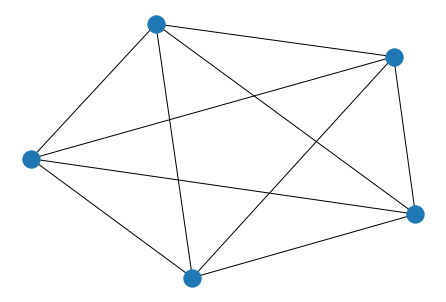

In [35]:
# NetworkX example

import matplotlib.pyplot as plt
from py2cytoscape import cyrest

nx_graph  = nx.complete_graph(5)
nx.draw(nx_graph)

#### write network to file
Cytoscape supports file times:
* Simple interaction file (SIF or .sif format)
* Nested network format (NNF or .nnf format)
* Graph Markup Language (GML or .gml format)
* XGMML (extensible graph markup and modelling language).
* SBML
* BioPAX
* GraphML (used in example)
* Delimited text
* Excel Workbook (.xls, .xlsx)
* Cytoscape.js JSON
* Cytoscape CX

In [36]:
nx.write_graphml(nx_graph, 'graph_from_networkx.graphml')

nx_to_cyto = cy.network.create_from('graph_from_networkx.graphml', collection="networkx")

## tables as DataFrame


Tables as DataFrame
Cytoscape has two main data types: Network and Table. Network is the graph topology, and Tables are properties for those graphs. For simplicity, this library has access to three basic table objects:

* Node Table
* Edge Table
* Network Table

For 99% of your use cases, you can use these three to store properties. Since pandas is extremely useful to handle table data, default data type for tables is DataFrame. However, you can also use other data types including:

* Cytoscape.js style JSON
* CSV
* TSV

In [37]:
# Get table from Cytoscape (networkx example)
node_table = nx_to_cyto.get_node_table()
edge_table = nx_to_cyto.get_edge_table()
network_table = nx_to_cyto.get_network_table()
node_table

,SUID,name,selected,shared name
0,10410,0,False,0
1,10411,1,False,1
2,10412,2,False,2
3,10413,3,False,3
4,10414,4,False,4


In [38]:
# more info
network_table.transpose().head()

,0
SUID,10400
__Annotations,[]
name,graph_from_networkx.graphml
selected,True
shared name,graph_from_networkx.graphml


### edit network topology using table data

adding and deleting nodes/ edges

In [39]:
# Add new nodes: Simply send the list of node names.  NAMES SHOULD BE UNIQUE!
new_node_names = ['a', 'b', 'c']
# Return value contains dictionary from name to SUID.
new_nodes = nx_to_cyto.add_nodes(new_node_names)

# Add new edges
# Send a list of tuples:  (source node SUID, target node SUID, interaction type)
new_edges = []
new_edges.append((new_nodes['a'], new_nodes['b'], 'type1'))
new_edges.append((new_nodes['a'], new_nodes['c'], 'type2'))
new_edges.append((new_nodes['b'], new_nodes['c'], 'type3'))

new_edge_ids = nx_to_cyto.add_edges(new_edges)
new_edge_ids

,source,target
SUID,,
10448,10442,10443
10449,10442,10444
10450,10443,10444


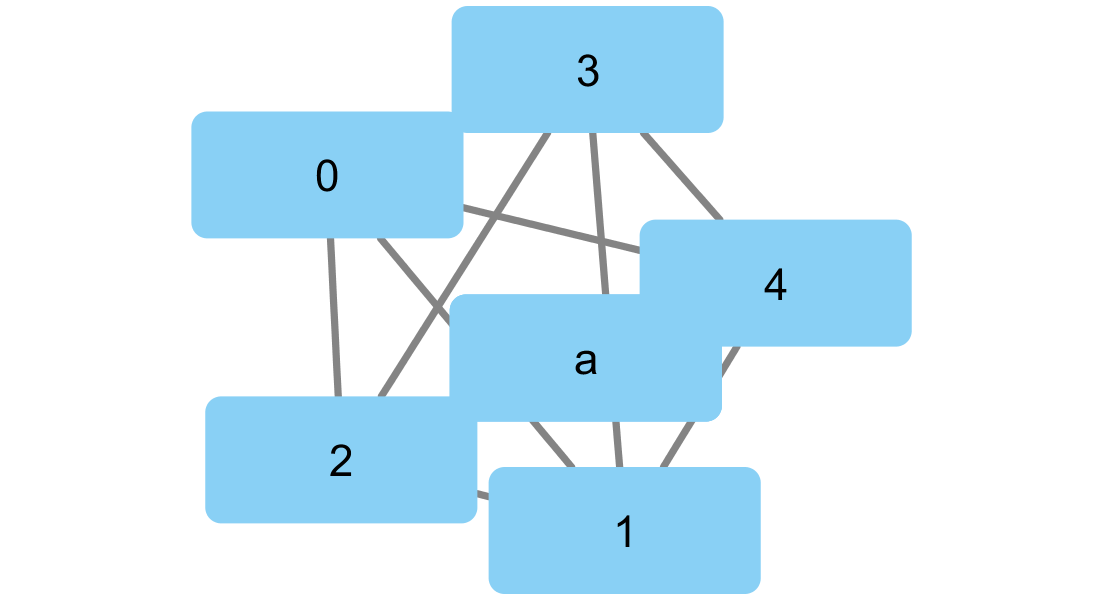

In [40]:
Image(nx_to_cyto.get_png(height=600))

In [41]:
# Delete node
nx_to_cyto.delete_node(new_nodes['a'])

# Delete edge
nx_to_cyto.delete_edge(new_edge_ids.index[0])

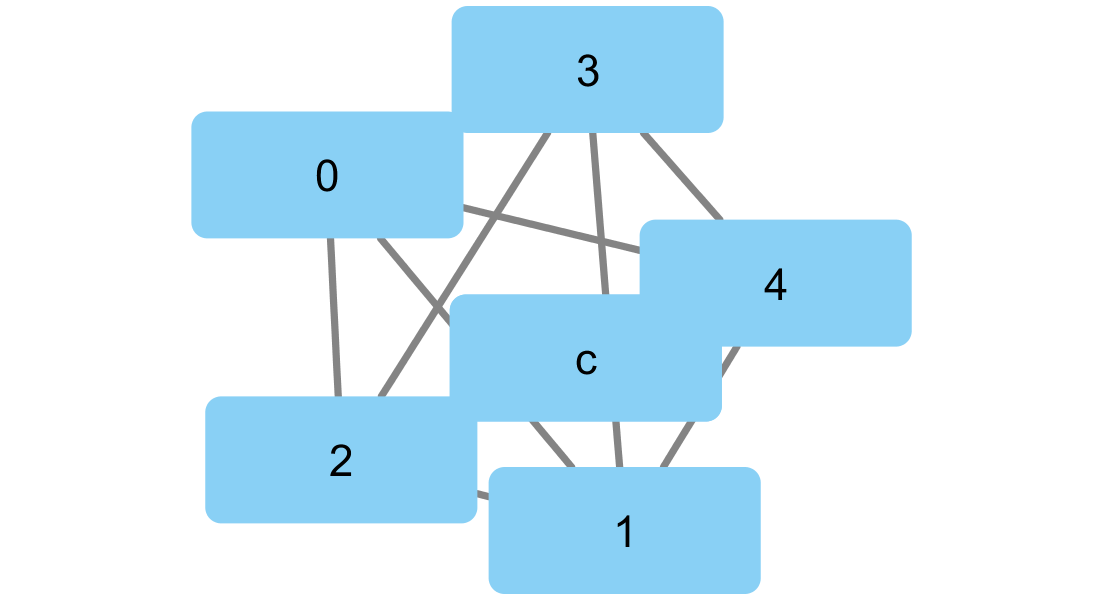

In [42]:
# updated network
Image(nx_to_cyto.get_png(height=600))

## Get the network from Cytoscape

You can retrieve data from network as the following forms:
* Cytoscape.js
* networkx
* DataFrame

In [43]:
# As Cytoscape.js (dict)
yeast1 = cy.network.create_from('galFiltered.sif')
yeast1_json = yeast1.to_json()

print(json.dumps(yeast1_json, indent=4))

{
    "target_cytoscapejs_version": "~2.1",
    "data": {
        "selected": true,
        "name": "galFiltered.sif_1",
        "shared_name": "galFiltered.sif_1",
        "source_location": "file:///C:\\Users\\ajshe\\OneDrive\\Documents\\Gitter_Lab_research\\CytoscapeAutomation\\py2cytoscape\\galFiltered.sif",
        "__Annotations": [],
        "SUID": 10454
    },
    "format_version": "1.0",
    "elements": {
        "edges": [
            {
                "data": {
                    "Source_Experimental_Role_ID": [],
                    "Complex_Expansion_ID": [],
                    "interaction": "pp",
                    "Target_Experimental_Role_ID": [],
                    "Target_Experimental_Role": [],
                    "Target_Participant_Detection_Method": [],
                    "Annotation": [],
                    "shared_name": "YDR277C (pp) YDL194W",
                    "Detection_Method": [],
                    "Source_Biological_Role": [],
                 

Number of Nodes: 7
Number of Edges: 11


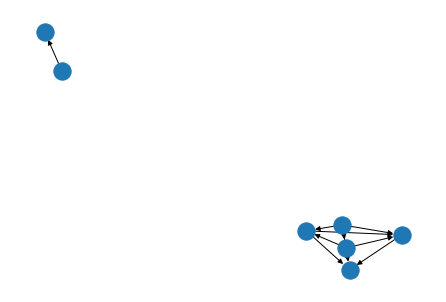

In [44]:
# As NetworkX graph object
s = nx_to_cyto.to_networkx()

num_nodes = s.number_of_nodes()
num_edges = s.number_of_edges()

print('Number of Nodes: ' + str(num_nodes))
print('Number of Edges: ' + str(num_edges))

nx.draw(s)

In [45]:
# As a simple, SIF-like DataFrame
yeast1_df = yeast1.to_dataframe()
yeast1_df.head()

,source,interaction,target
0,4701,pp,4702
1,4701,pp,4399
2,4699,pp,4680
3,4698,pp,4697
4,4698,pp,4584


## Visual Styles
use wrapper API to access Visual Styles

In [46]:
# Get all existing Visual Styles
import json
styles = cy.style.get_all()
print(json.dumps(styles, indent=4))

# Create a new style
style1 = cy.style.create('sample_style1')

# Get a reference to the existing style
default_style = cy.style.create('default')

print(style1.get_name())
print(default_style.get_name())

# Get all available Visual Properties
print(len(cy.style.vps.get_all()))

# Get  Visual Properties for each data type
node_vps = cy.style.vps.get_node_visual_props()
edge_vps = cy.style.vps.get_edge_visual_props()
network_vps = cy.style.vps.get_network_visual_props()

print(pd.Series(edge_vps).head())

[
    "default black",
    "Gradient1",
    "Sample2",
    "Directed",
    "Minimal",
    "Solid",
    "Universe",
    "Big Labels",
    "default",
    "Marquee",
    "Nested Network Style",
    "Ripple",
    "Sample1",
    "Sample3",
    "Curved"
]
sample_style1
default
109
0    EDGE_SOURCE_ARROW_UNSELECTED_PAINT
1                             EDGE_BEND
2                  EDGE_LABEL_FONT_FACE
3                            EDGE_WIDTH
4                            EDGE_LABEL
dtype: object


### Set default values 

To set default values for Visual Properties, simply pass key-value pairs as dictionary.

In [47]:
# Prepare key-value pair for Style defaults

new_defaults = {
    # Node defaults
    'NODE_FILL_COLOR': '#eeeeff',
    'NODE_SIZE': 20,
    'NODE_BORDER_WIDTH': 0,
    'NODE_TRANSPARENCY': 120,
    'NODE_LABEL_COLOR': 'white',
    
    # Edge defaults
    'EDGE_WIDTH': 3,
    'EDGE_STROKE_UNSELECTED_PAINT': '#aaaaaa',
    'EDGE_LINE_TYPE': 'LONG_DASH',
    'EDGE_TRANSPARENCY': 120,
    
    # Network defaults
    'NETWORK_BACKGROUND_PAINT': 'black'
}

# Update
style1.update_defaults(new_defaults)

# Apply the new style
cy.style.apply(style1, yeast1)

### Visual Mappings for style

In [48]:
# Passthrough mapping
style1.create_passthrough_mapping(column='name', col_type='String', vp='NODE_LABEL')

# Discrete mapping: Simply prepare key-value pairs and send it
kv_pair = {
    'pp': 'pink',
    'pd': 'green'
}
style1.create_discrete_mapping(column='interaction', 
                               col_type='String', vp='EDGE_STROKE_UNSELECTED_PAINT', mappings=kv_pair)

# Continuous mapping
points = [
    {
        'value': '1.0',
        'lesser':'white',
        'equal':'white',
        'greater': 'white'
    },
    {
        'value': '20.0',
        'lesser':'green',
        'equal':'green',
        'greater': 'green'
    }
]

minimal_style = cy.style.create('Minimal')
minimal_style.create_continuous_mapping(column='Degree', col_type='Double', vp='NODE_FILL_COLOR', points=points)

# Or, use utility for simple mapping
simple_slope = StyleUtil.create_slope(min=1, max=20, values=(10, 60))
minimal_style.create_continuous_mapping(column='Degree', col_type='Double', vp='NODE_SIZE', points=simple_slope)

# Apply the new style
cy.style.apply(minimal_style, nx_to_cyto)

### Layouts 

Currently, this supports automatic layouts with default parameters.



In [49]:
# Get list of available layout algorithms
layouts = cy.layout.get_all()
print(json.dumps(layouts, indent=4))

[
    "attribute-circle",
    "stacked-node-layout",
    "degree-circle",
    "circular",
    "attributes-layout",
    "kamada-kawai",
    "force-directed",
    "cose",
    "grid",
    "hierarchical",
    "fruchterman-rheingold",
    "isom",
    "force-directed-cl"
]


In [50]:
# Apply layout
cy.layout.apply(name='circular', network=yeast1)

yeast1.get_views()
yeast_view1 = yeast1.get_first_view()
node_views = yeast_view1['elements']['nodes']
df3 = pd.DataFrame(node_views)
df3.head()

,data,position,selected
0,"{'SelfLoops': 0.0, 'annotation_GO_CELLULAR_COM...","{'y': 582.6852760675076, 'x': -232.0911960492358}",False
1,"{'SelfLoops': 0.0, 'annotation_GO_CELLULAR_COM...","{'y': 518.6801522445817, 'x': -199.11629461781...",False
2,"{'SelfLoops': 0.0, 'annotation_GO_CELLULAR_COM...","{'y': 1534.950688763643, 'x': -1063.2901147187...",False
3,"{'SelfLoops': 0.0, 'annotation_GO_CELLULAR_COM...","{'y': 196.63970699966808, 'x': 1088.1841390547...",False
4,"{'SelfLoops': 0.0, 'annotation_GO_CELLULAR_COM...","{'y': -1672.6941862457077, 'x': -658.097632755...",False


# Integrate py2cytoscape into TPS workflow 

use py2cytoscape functionality in order to produce networks produced by TPS. This workflow follows the same steps as described above. 

## import files
* cytoscape style file
* annotations file
* graph (.sif) file from TPS output

## run workflow
* following basic workflow steps
* adding annotations and style


In [51]:
baseDir = r"C:\Users\ajshe\Anaconda3\envs\py2cyto\tps"
visualization_scripts = os.path.join(baseDir, 'visualization_scripts')
sys.path.insert(1, visualization_scripts)

print(baseDir)

output = os.path.join(baseDir, 'htcondor_results', 'results_reproduce_egfr_tps_051320', 'output.sif')

style = os.path.join(baseDir, 'visualization_scripts', 'tps_style.xml')

annotations = r"C:\Users\ajshe\Anaconda3\envs\py2cyto\tps\evaluation\2020-05-12-and-wolf-yadlin-TPS-cytoscape\2020-05-12-and-wolf-yadlin-TPS-cytoscape\refactored_annotations_float_delim_052020.txt"

print(output)
print(style)
print(annotations)


C:\Users\ajshe\Anaconda3\envs\py2cyto\tps
C:\Users\ajshe\Anaconda3\envs\py2cyto\tps\htcondor_results\results_reproduce_egfr_tps_051320\output.sif
C:\Users\ajshe\Anaconda3\envs\py2cyto\tps\visualization_scripts\tps_style.xml
C:\Users\ajshe\Anaconda3\envs\py2cyto\tps\evaluation\2020-05-12-and-wolf-yadlin-TPS-cytoscape\2020-05-12-and-wolf-yadlin-TPS-cytoscape\refactored_annotations_float_delim_052020.txt


In [52]:
from py2cytoscape import cyrest
import time
# create cyrest client
cyy = cyrest.cyclient()

# Load network from somewhere
print("---loading network file")
tps = cy.network.create_from(output, collection='TPS')
print("---Done")
time.sleep(2)

# Apply layout
# list of styles to apply
# only contains the one style loaded from style file
print("---apply style file")
style = cyy.vizmap.load_file(style)
print("---style name: ", style)

# Apply style
cyy.vizmap.apply(style[0])

# Apply annotations to network
cyy.table.import_file(afile=annotations,
                     firstRowAsColumnNames=True,
                      keyColumnIndex='1',
                      startLoadRow='0',
                     dataTypeList="s,s,b,dl,dl,dl,dl,dl,dl,dl,dl,dl,dl,dl,dl,dl,dl,dl,dl,dl,s,il,il,il,il,il,s,il,il,il,il,il,il"
                     )

---loading network file
---Done
---apply style file
---style name:  ['TPS']


{'mappedTables': [11527]}

**use Image to display static image of graph open in Cytoscape session**

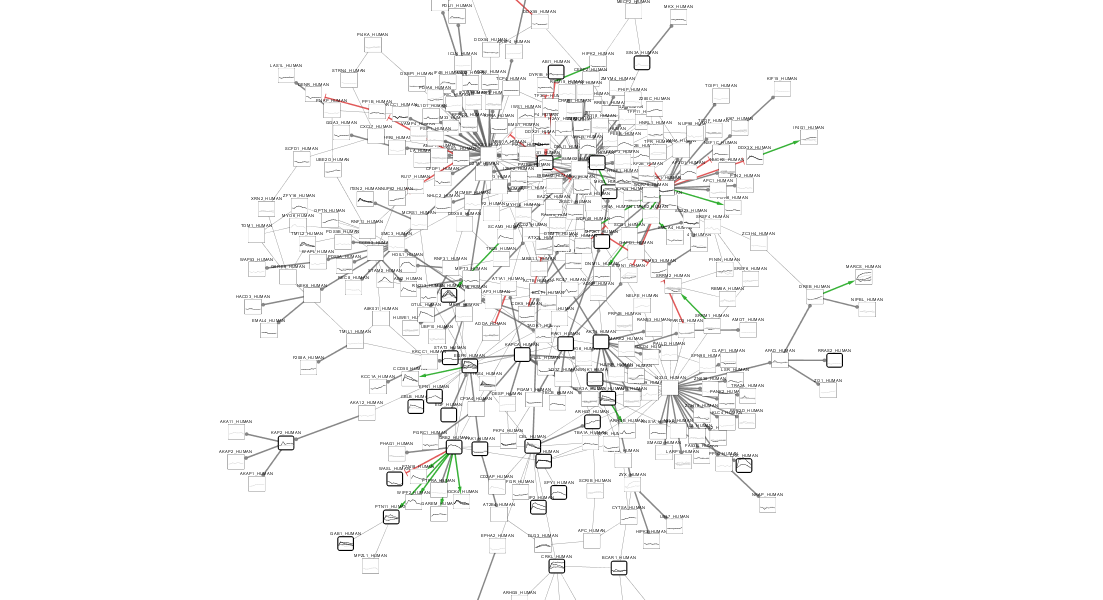

In [53]:
Image(tps.get_png(height=600))

## select node / edges to create subnetworks

first select node in Cytoscape that will be used to generate subnetworks (this can also be automated using `network.get_neighbors`)

In [54]:
sub_data = cyy.network.select(firstNeighbors='outgoing', adjacentEdges='true' )
sub_data

{'edges': [11919,
  11858,
  12212,
  11828,
  11803,
  11774,
  11742,
  12161,
  12194,
  12260,
  12167,
  11847,
  12008,
  11946,
  12108,
  12076,
  11564,
  11917,
  12109,
  12206],
 'nodes': [12160,
  11857,
  12259,
  11846,
  11945,
  12107,
  12075,
  11563,
  11740,
  11916,
  11741,
  11918]}

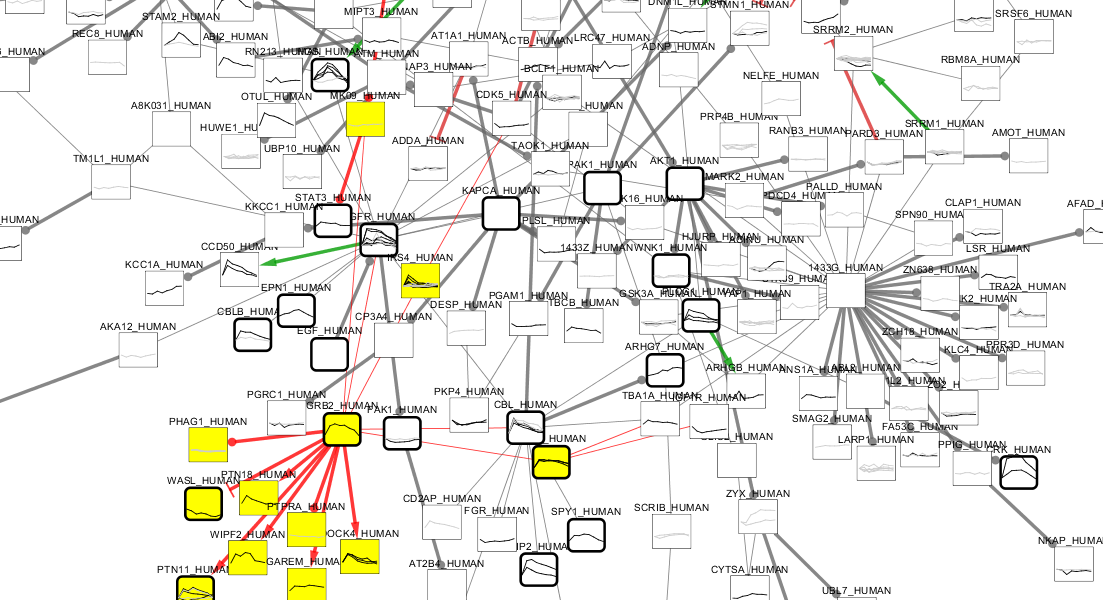

In [55]:
Image(tps.get_png(height=600))

### grab netowork attributes


In [ ]:
# attrs = cyy.node.list_attributes()
# print(attrs)
# attrs_df = tps.get_node_table()
# attrs_df['SUID']
# selected_nodes = sub_data['nodes']
    
# new = attrs_df[attrs_df['SUID'].isin(selected_nodes)]
# new

# new_nodes = new['name']
# new_nodes
# node_values = "name:" + ",".join(new_nodes) 
# new_net = cyy.network.create(source='current', excludeEdges='false', nodeList=node_values)

# fig=cyy.networks.getFirstImageAsPng(networkId=cyy.network.get()["SUID"],h=None)
# Image(fig.content)

In [56]:
# print column names
attrs = cyy.node.list_attributes()
print(attrs)

['SUID', 'shared name', 'name', 'selected', 'NodeType', 'ReferencePathway', 'SigPeptide1', 'SigPeptide2', 'SigPeptide3', 'SigPeptide4', 'SigPeptide5', 'SigPeptide6', 'InsigPeptide1', 'InsigPeptide2', 'InsigPeptide3', 'InsigPeptide4', 'InsigPeptide5', 'InsigPeptide6', 'InsigPeptide7', 'InsigPeptide8', 'InsigPeptide9', 'InsigPeptide10', 'ActivitySummary2min', 'ActivitySummary4min', 'ActivitySummary8min', 'ActivitySummary16min', 'ActivitySummary32min', 'ActivitySummary64min', 'ActivitySummary128min', 'FirstActive', 'HeatMapBg1', 'HeatMapBg2', 'HeatMapBg3', 'HeatMapBg4', 'HeatMapBg5', 'HeatMapBg6']


In [57]:
# SUIDs of network
attrs_df = tps.get_node_table()
attrs_df['SUID']

0      11547
1      11548
2      11550
3      11551
4      11553
       ...  
306    12253
307    12259
308    12262
309    12265
310    12267
Name: SUID, Length: 311, dtype: int64

In [58]:
# nodes used to generate subnetwork
selected_nodes = sub_data['nodes']

# filter attribute data
selected_df = attrs_df[attrs_df['SUID'].isin(selected_nodes)]

# new table of subnetwork
selected_df

,ActivitySummary128min,ActivitySummary16min,ActivitySummary32min,ActivitySummary4min,ActivitySummary64min,ActivitySummary8min,FirstActive,InsigPeptide1,InsigPeptide10,InsigPeptide2,...,SUID,SigPeptide1,SigPeptide2,SigPeptide3,SigPeptide4,SigPeptide5,SigPeptide6,name,selected,shared name
11,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",Not active,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",0|0|0|0|0|0|0,"[0.0, -0.180529, 0.064888, -0.264573, -0.00426...",NaN,"[0.0, 1.810265, 1.476189, 2.23072, 1.720158, 1...",...,11563,"[0.0, 2.144711, 1.649273, 2.486949, 1.895915, ...","[0.0, -0.507605, -0.670649, -0.328642, -0.2560...","[0.0, 1.676137, 1.236169, 0.95818, 0.874489, 0...",NaN,NaN,NaN,PTN11_HUMAN,True,PTN11_HUMAN
115,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",Not active,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",0|0|0|0|0|0|0,NaN,NaN,NaN,...,11740,"[0.0, 2.114914, 2.558819, 2.172323, 2.23812, 1...",NaN,NaN,NaN,NaN,NaN,GRB2_HUMAN,True,GRB2_HUMAN
116,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",Not active,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",0|0|0|0|0|0|0,NaN,NaN,NaN,...,11741,"[0.0, 1.768273, 1.453163, 1.783947, 1.652291, ...","[0.0, 1.900981, 1.87847, 1.595921, 1.518947, 1...","[0.0, 1.611012, 1.515252, 1.59177, 1.639182, 1...",NaN,NaN,NaN,SHC1_HUMAN,True,SHC1_HUMAN
164,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",Not active,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",0|0|0|0|0|0|0,NaN,NaN,NaN,...,11846,"[0.0, 1.826049, 1.020265, 0.592653, 0.213041, ...",NaN,NaN,NaN,NaN,NaN,PTN18_HUMAN,True,PTN18_HUMAN
170,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",Not active,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",0|0|0|0|0|0|0,"[0.0, -0.348958, -0.370795, -0.049132, -0.1291...",NaN,NaN,...,11857,NaN,NaN,NaN,NaN,NaN,NaN,MK09_HUMAN,True,MK09_HUMAN
197,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",Not active,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",0|0|0|0|0|0|0,NaN,NaN,NaN,...,11916,"[0.0, 1.749393, 1.153493, 0.215052, -0.139721,...","[0.0, 1.98792, 1.648104, 1.040572, 0.660593, 0...","[0.0, 1.861799, 1.591559, 0.571783, 0.375542, ...",NaN,NaN,NaN,DOCK4_HUMAN,True,DOCK4_HUMAN
198,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",Not active,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",0|0|0|0|0|0|0,NaN,NaN,NaN,...,11918,"[0.0, 1.06826, 1.011596, 0.904284, 1.285192, 1...",NaN,NaN,NaN,NaN,NaN,GAREM_HUMAN,True,GAREM_HUMAN
210,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",Not active,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",0|0|0|0|0|0|0,"[0.0, 0.256457, -0.145658, -0.066684, -0.12661...",NaN,"[0.0, -0.115721, 0.261709, 0.162688, -0.006151...",...,11945,"[0.0, 2.028588, 1.016132, 0.513704, 0.525187, ...","[0.0, 2.616739, 1.715346, 0.781296, 0.70774, 0...","[0.0, 0.956158, 0.44401, -0.075182, -0.054117,...","[0.0, 1.162557, 0.272129, 0.100486, 0.064723, ...","[0.0, 0.72842, 0.499451, 0.329973, 0.189143, 0...","[0.0, 0.258004, -0.308821, -0.217765, -0.35362...",IRS4_HUMAN,True,IRS4_HUMAN
257,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",Not active,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",0|0|0|0|0|0|0,"[0.0, 0.101141, -0.157801, -0.250828, -0.34115...",NaN,"[0.0, 0.049483, -0.072741, -0.422097, -0.45256...",...,12075,NaN,NaN,NaN,NaN,NaN,NaN,PHAG1_HUMAN,True,PHAG1_HUMAN
266,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",Not active,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",0|0|0|0|0|0|0,NaN,NaN,NaN,...,12107,"[0.0, 2.145038, 1.621865, 2.498247, 2.260794, ...",NaN,NaN,NaN,NaN,NaN,WIPF2_HUMAN,True,WIPF2_HUMAN


In [59]:
# generate new network
new_nodes = selected_df['name']
new_nodes
node_values = "name:" + ",".join(new_nodes) 
new_net = cyy.network.create(source='current', excludeEdges='false', nodeList=node_values)

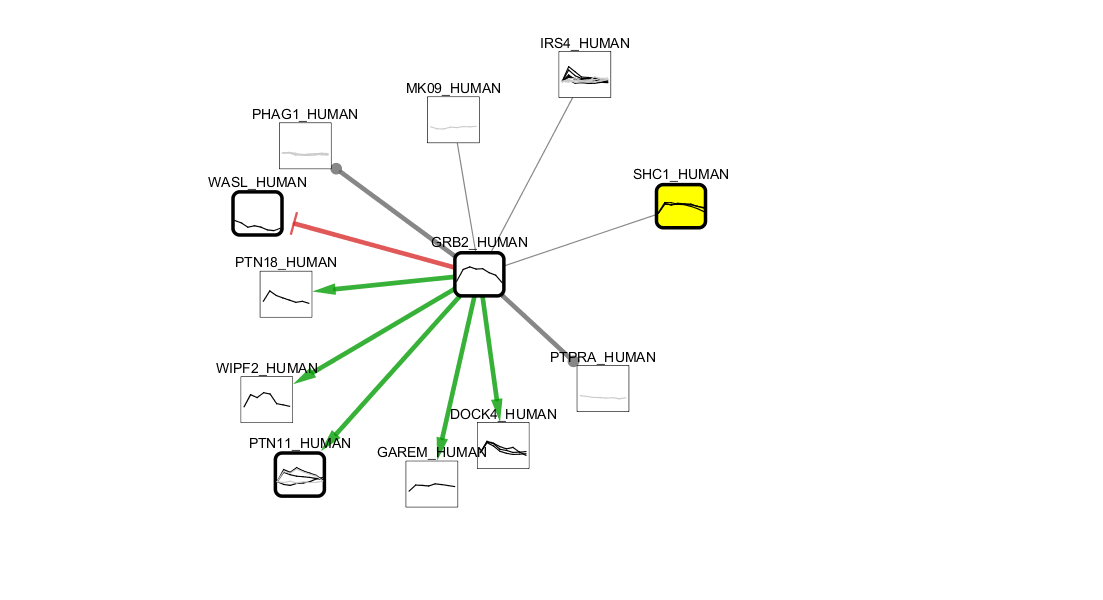

In [60]:
fig=cyy.networks.getFirstImageAsPng(networkId=cyy.network.get()["SUID"],h=None)
Image(fig.content)

# Other useful examples

In [61]:
import numpy as np
matrix1 = np.array([
    [0, 1, 1, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 0, 0, 0]])

net1 = cy.network.create_from_ndarray(matrix1, name='binary sample')
cy.layout.apply(network=net1)
cy.layout.fit(network=net1)

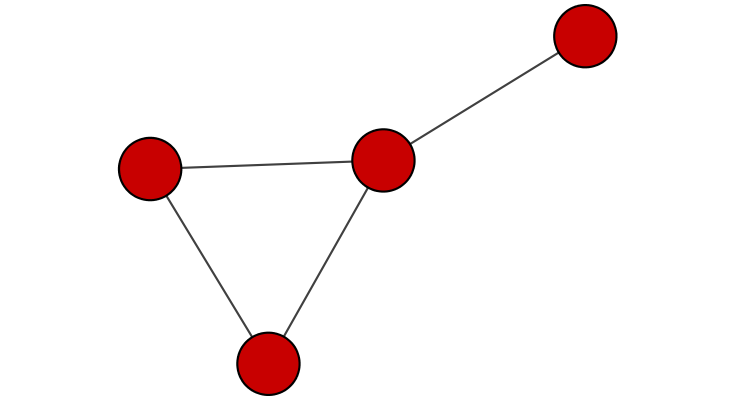

In [62]:
Image(net1.get_png(height=400))

## use function to create random graph

In [63]:
# Create a random graph
matrix_size = 10
weighted = np.empty((matrix_size,matrix_size,))
weighted[:] = np.NAN

row_idx = 0
for row in weighted:
    idx = row_idx
    while idx < matrix_size:
        if idx != row_idx and np.random.randint(2):
            weighted[row_idx][idx] = np.random.randn()
        idx +=1
    row_idx += 1

# for printing
df = pd.DataFrame(weighted)
df.head(10)

,0,1,2,3,4,5,6,7,8,9
0,NaN,1.27738,NaN,NaN,-0.423594,NaN,1.717092,2.746283,NaN,NaN
1,NaN,NaN,0.574601,NaN,-0.238585,-0.025137,NaN,NaN,-0.047537,NaN
2,NaN,NaN,NaN,1.392684,NaN,-0.185165,0.143964,NaN,NaN,-1.246143
3,NaN,NaN,NaN,NaN,NaN,NaN,-0.040908,0.163664,0.089140,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,1.079418,NaN,0.910736,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.185713,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.867089,0.043382,-1.462181
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.047404
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
from py2cytoscape.data.util_network import NetworkUtil as util
from py2cytoscape.data.style import StyleUtil as s_util

weight_min = weighted.min() 
weight_max = weighted.max() 
 
net2 = cy.network.create_from_ndarray(weighted, name='weighted sample', weighted=True)
cy.layout.apply(network=net2, name="circular")
cy.layout.fit(network=net2)

# Styling
style_s2 = cy.style.create('Sample2')

defaults = {    
    'NODE_SIZE': 12,
    'NODE_BORDER_WIDTH': 2,
    'NODE_LABEL_FONT_SIZE': 14,
    'NODE_LABEL_COLOR': '#555555',
    'EDGE_TRANSPARENCY': 100,
    'EDGE_STROKE_UNSELECTED_PAINT': '#999999',
    'NETWORK_BACKGROUND_PAINT': '#FFFFFF'
}
style_s2.update_defaults(defaults)
score_to_width = s_util.create_slope(min=weight_min, max=weight_max, values=(1, 8))
style_s2.create_continuous_mapping(column='weight', vp='EDGE_WIDTH', col_type='Double', points=score_to_width)
cy.style.apply(style=style_s2, network=net2)

C:\Users\ajshe\Anaconda3\envs\py2cyto_sandbox\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\ajshe\Anaconda3\envs\py2cyto_sandbox\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


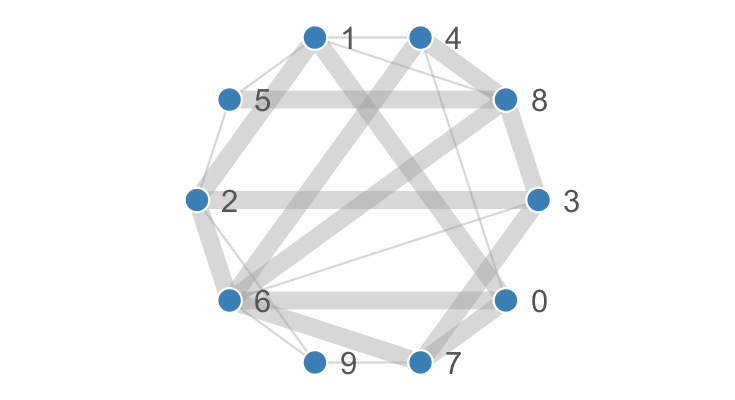

In [65]:
Image(net2.get_png(height=400))

In [66]:
d1 = np.random.randint(2, size=(10, 10))
dn1 = cy.network.create_from_ndarray(d1, name="Random")
cy.layout.apply(network=dn1, name="kamada-kawai")
style_s3 = cy.style.create('Sample3')
cy.style.apply(style=style_s3, network=dn1)

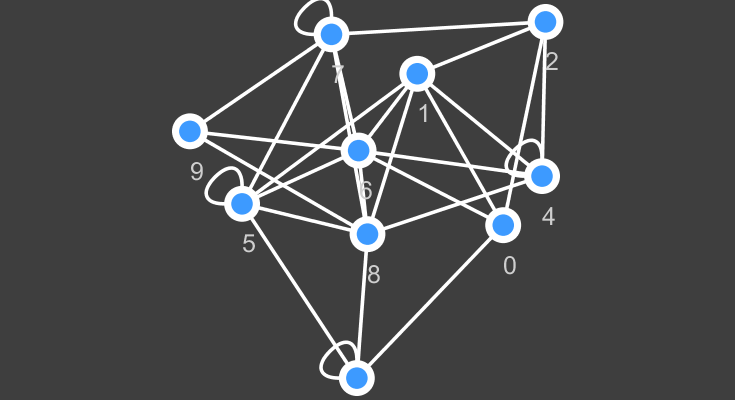

In [67]:
Image(dn1.get_png(height=400))

In [68]:
d2 = np.ones((100,100))
dn2 = cy.network.create_from_ndarray(d2, name="Complete")
cy.layout.apply(network=dn2, name="circular")
cy.layout.fit(network=dn2)

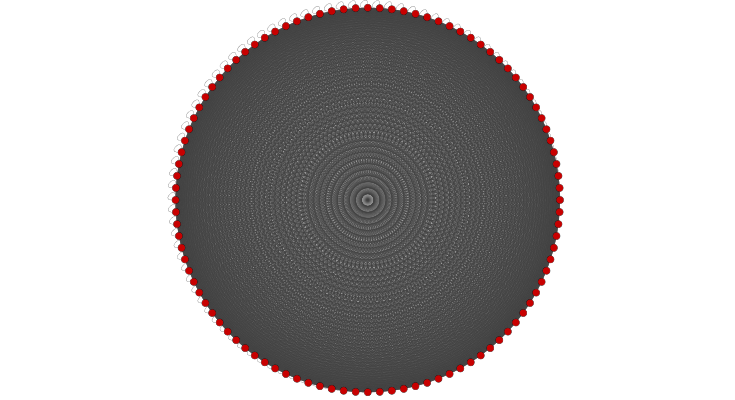

In [69]:
Image(dn2.get_png(height=400))

In [72]:
baseDir = os.path.abspath(os.path.join('..'))
output_session = os.path.join(baseDir, 'sessions', 'py2cytoscape_session')

In [73]:
cy.session.save(output_session)

<Response [200]>